### 1 - Install the necessary packages

In [ ]:
!pip -q install ./python

### 2 - Importing the necessary packages


We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
import torch
import matplotlib.pyplot as plt
%matplotlib inline

import random
from IPython.display import clear_output

from models import *
from agent import Agent

import torch
import torch.nn as nn
import torch.optim as optim

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
# 1 agent
#env = UnityEnvironment(file_name="C:\\Users\\levy0\\Documents\\Udacity\\\\projects\\dependencies\\Reacher_Windows_x86_64\\Reacher.exe")

# 20 agents
env = UnityEnvironment(file_name="C:\\Users\\levy0\\Documents\\Udacity\\\\projects\\dependencies\\Reacher_20_Windows_x86_64\\Reacher.exe")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


  ### 4 - Getting some information of the state and action spaces

In [3]:
env_info = env.reset(train_mode=True)[brain_name]
states = env_info.vector_observations
print(states)

[[ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
  -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
   1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  7.90150833e+00 -1.00000000e+00
   1.25147629e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  -5.22214413e-01]
 [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
  -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
   1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  7.95617676e+00 -1.0000

In [4]:
def new_trajectory():
        t = {}
        t['states']  = []
        t['rewards'] = []
        t['probs']   = []
        t['actions'] = []
        t['values']  = []
        t['dones']   = []
        t['scores']  = 0.0
        return t

def ppo_trainning():
    
    env_info = env.reset(train_mode=True)[brain_name]
    state_size = env_info.vector_observations.shape[1]
    action_size = brain.vector_action_space_size
    agent = Agent(state_size, action_size)

    scores = []
    scores_window = deque(maxlen=100)
    solved = False
    
    for i_episode in range(500):

        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        t = new_trajectory()
        
        for i in range(1000):
            actions, log_probs, values = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            t['states'].append(states)
            t['rewards'].append(rewards)
            t['probs'].append(log_probs)
            t['actions'].append(actions)
            t['values'].append(values)
            t['dones'].append(dones)
            t['scores'] += np.mean(rewards)

            states = next_states
            if np.any(dones):
                break
        agent.step(t)
        scores.append(t['scores'])
        scores_window.append(t['scores'])
        if i_episode % 20 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window) >= 30.:
            solved = True
            episode_solved = i_episode-100
            torch.save(agent.policy.state_dict(), 'checkpoint_trained.pth')
            break
    if solved:
        print('\nEnvironment solved in {:d} episodes!'.format(episode_solved))
    else:
        print("Environment not solved")
        
    return scores

### 7 - Trainning and solving

Episode 0	Average Score: 0.10
Episode 20	Average Score: 0.91
Episode 40	Average Score: 2.04
Episode 60	Average Score: 3.31
Episode 80	Average Score: 4.51
Episode 100	Average Score: 5.89
Episode 120	Average Score: 8.66
Episode 140	Average Score: 11.86
Episode 160	Average Score: 15.35
Episode 180	Average Score: 19.13
Episode 200	Average Score: 22.95
Episode 220	Average Score: 26.54
Episode 240	Average Score: 29.69

Environment solved in 143 episodes!


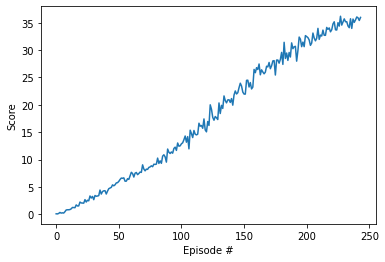

In [5]:
scores = ppo_trainning()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 8 - Closing the environment

In [ ]:
env.close()